# Import packages and datasets

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.cluster import k_means
from sklearn.decomposition import PCA

In [6]:
!wget --max-redirect=20 -O survey_response_data.csv https://www.dropbox.com/s/4d7nvjnjer6854w/survey_response_data.csv?dl=0

--2022-09-25 17:27:52--  https://www.dropbox.com/s/4d7nvjnjer6854w/survey_response_data.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/4d7nvjnjer6854w/survey_response_data.csv [following]
--2022-09-25 17:27:52--  https://www.dropbox.com/s/raw/4d7nvjnjer6854w/survey_response_data.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc27580518bc19ddaddeb4e6e978.dl.dropboxusercontent.com/cd/0/inline/BtovdQvyYVnLaVI5RSUq4SSDKIso2wgSHnnvLYWCbCYgmspToP1lpQksFHKLyEIkBfQ3klmKU3O2_XHjrBF7CcvYRf2mrnUZc071gSlMOE5eLuiAwLFq1OMXMA6HBqrjG0ylRD2Ss8TTv87IET_GbcI3P6vxT7sA6WsVJBWJWg9W0A/file# [following]
--2022-09-25 17:27:53--  https://uc27580518bc19ddaddeb4e6e978.dl.dropboxusercontent.com/cd/0/inline/BtovdQvyYVnLaVI5RSUq4SSDKIso2wgSHnnv

# 1. K-means Clustering and Principal Components Analysis with 6 Features

## Read file

In [7]:
ceo_data = pd.read_csv('/content/survey_response_data.csv', low_memory=False)
ceo_data.set_index(['id'], inplace=True)
ceo_data = ceo_data[(ceo_data.level1 == 'interacting')]
ceo_data = ceo_data[ceo_data.type != 'personal_family']
ceo_data = ceo_data[ceo_data.index != 1115]

ceo_data.head()

,finance,mkting,production,strategy,hr,bunits,other,admin,board,chairman,...,pemployee,ins,out,n_functions,type,level1,F_duration,F_planned,F_participants,all_combined
id,,,,,,,,,,,,,,,,,,,,,
607,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,2,meeting,interacting,1hr,planned,two_plus_ppl,interacting__meeting__1hr__planned__two_plus_p...
607,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,2,meeting,interacting,1hr,planned,two_plus_ppl,interacting__meeting__1hr__planned__two_plus_p...
607,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,2,meeting,interacting,1hr,planned,two_plus_ppl,interacting__meeting__1hr__planned__two_plus_p...
607,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,2,meeting,interacting,1hr,planned,two_plus_ppl,interacting__meeting__1hr__planned__two_plus_p...
607,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2,meeting,interacting,1hr,unplanned,two_plus_ppl,interacting__meeting__1hr__unplanned__two_plus...


## Select 6 features 

In [8]:
# 對每位 CEO 選擇六個變數作為features
# CONTRUCT DATASET WITH SIX FEATURES, EXPRESSED AS TIME SHARE DURING WEEK

agg_data = pd.DataFrame()

In [9]:
# feature1: F_duration 為 1hrplus 次數

df1 = pd.crosstab(
      ceo_data.index, 
      ceo_data.F_duration
      )

agg_data['long'] = df1['1hrplus']
agg_data

,long
row_0,
1,44
2,106
3,41
4,145
5,129
...,...
1110,70
1111,44
1112,40


In [10]:
# feature2: F_planned 為 planned 次數

df2 = pd.crosstab(
      ceo_data[ceo_data.F_planned != 'missing'].index, 
      ceo_data[ceo_data.F_planned != 'missing'].F_planned
      )

agg_data['planned'] = df2['planned']
agg_data

,long,planned
row_0,,
1,44,54
2,106,134
3,41,32
4,145,145
5,129,143
...,...,...
1110,70,96
1111,44,54
1112,40,68


In [11]:
# feature3: F_participants 為 missing 次數

df3 = pd.crosstab(
      ceo_data[ceo_data.F_participants != 'missing'].index,
      ceo_data[ceo_data.F_participants != 'missing'].F_participants
      )

agg_data['large'] = df3['two_plus_ppl']
agg_data

,long,planned,large
row_0,,,
1,44,54,58
2,106,134,43
3,41,32,40
4,145,145,126
5,129,143,120
...,...,...,...
1110,70,96,108
1111,44,54,19
1112,40,68,32


In [12]:
# feature4: out 為 1 次數

# ceo_data['ins_alone'] = 0
# ceo_data.loc[(ceo_data.ins == 1.0) & (ceo_data.out == 0.0), 'ins_alone'] = 1

# ceo_data['out_alone'] = 0
# ceo_data.loc[(ceo_data.ins == 0.0) & (ceo_data.out == 1.0), 'out_alone'] = 1

# ceo_data['ins_out'] = 0
# ceo_data.loc[(ceo_data.ins == 1.0) & (ceo_data.out == 1.0), 'ins_out'] = 1

# df4 = pd.crosstab(ceo_data.index, ceo_data.ins_alone)
# df4a = pd.crosstab(ceo_data.index, ceo_data.ins)

# df5 = pd.crosstab(ceo_data.index, ceo_data.ins_out)
df5a = pd.crosstab(
      ceo_data.index, 
      ceo_data.out
      )

agg_data['out'] = df5a[1]
agg_data

,long,planned,large,out
row_0,,,,
1,44,54,58,2
2,106,134,43,46
3,41,32,40,14
4,145,145,126,21
5,129,143,120,55
...,...,...,...,...
1110,70,96,108,58
1111,44,54,19,30
1112,40,68,32,36


In [13]:
# feature5: groupcom, bunits, coo, cao 為 1 的次數相加

# df_production = pd.crosstab(ceo_data.index, ceo_data.production)
df_groupcom = pd.crosstab(ceo_data.index, ceo_data.groupcom)
df_bunits = pd.crosstab(ceo_data.index, ceo_data.bunits)
df_coo = pd.crosstab(ceo_data.index, ceo_data.coo)
df_cao = pd.crosstab(ceo_data.index, ceo_data.cao)

agg_data['coordinate1'] = df_groupcom[1] + df_bunits[1] + df_coo[1] + df_cao[1]
agg_data

,long,planned,large,out,coordinate1
row_0,,,,,
1,44,54,58,2,4
2,106,134,43,46,12
3,41,32,40,14,0
4,145,145,126,21,128
5,129,143,120,55,0
...,...,...,...,...,...
1110,70,96,108,58,0
1111,44,54,19,30,27
1112,40,68,32,36,8


In [14]:
# feature6: n_functions>1 的次數

ceo_data['coordinate'] = 0
ceo_data.loc[ceo_data.n_functions > 1, 'coordinate'] = 1
ceo_data['activity_dummy'] = 1
df6 = pd.crosstab(ceo_data.index, ceo_data.coordinate)

agg_data['coordinate2'] = df6[1]
agg_data

,long,planned,large,out,coordinate1,coordinate2
row_0,,,,,,
1,44,54,58,2,4,12
2,106,134,43,46,12,26
3,41,32,40,14,0,24
4,145,145,126,21,128,38
5,129,143,120,55,0,109
...,...,...,...,...,...,...
1110,70,96,108,58,0,46
1111,44,54,19,30,27,11
1112,40,68,32,36,8,14


## Descriptive statistics of the dataset

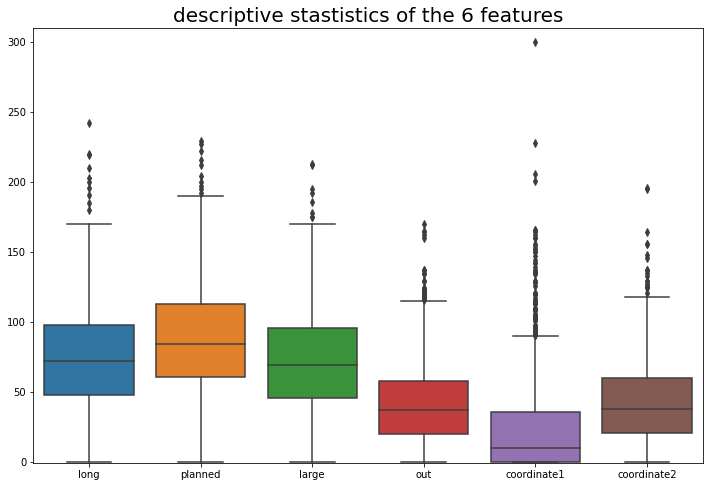

,long,planned,large,out,coordinate1,coordinate2
count,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000
mean,75.631957,87.826750,72.467684,41.495512,24.649013,43.301616
std,36.760915,38.234459,35.058074,28.544923,35.583365,30.232294
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,61.000000,46.000000,20.000000,0.000000,21.000000
50%,72.000000,84.000000,69.000000,37.000000,10.000000,38.000000
75%,97.750000,113.000000,96.000000,58.000000,36.000000,60.000000
max,242.000000,229.000000,213.000000,170.000000,300.000000,196.000000


In [15]:
fig = plt.figure(figsize = (12, 8))
sns.boxplot(data = agg_data)
plt.title('descriptive stastistics of the 6 features', fontsize=20)
plt.ylim(-0.5, 310)
plt.show()

agg_data.describe()

## PRINCIPAL COMPONENTS DECOMPOSITION

In [16]:
# 將各feature以佔每日時間的比例為表示方式

activities = ceo_data['activity_dummy'].groupby(ceo_data.index).agg(np.sum)
agg_data_share = agg_data.div(activities, axis=0)

agg_data_share

,long,planned,large,out,coordinate1,coordinate2
row_0,,,,,,
1,0.709677,0.870968,0.935484,0.032258,0.064516,0.193548
2,0.697368,0.881579,0.282895,0.302632,0.078947,0.171053
3,0.759259,0.592593,0.740741,0.259259,0.000000,0.444444
4,0.979730,0.979730,0.851351,0.141892,0.864865,0.256757
5,0.902098,1.000000,0.839161,0.384615,0.000000,0.762238
...,...,...,...,...,...,...
1110,0.486111,0.666667,0.750000,0.402778,0.000000,0.319444
1111,0.435644,0.534653,0.188119,0.297030,0.267327,0.108911
1112,0.579710,0.985507,0.463768,0.521739,0.115942,0.202899


In [17]:
pca = PCA(n_components=6)
pca.fit(agg_data_share)
agg_data_share_pca = pca.transform(agg_data_share)
agg_data_share_pca

array([[ 0.02804685,  0.00683771,  0.0841046 , -0.44361393, -0.10861429,
         0.24410871],
       [-0.26073301, -0.07608859, -0.26282252, -0.13342399,  0.03569118,
        -0.17095992],
       [-0.05875637,  0.09606108,  0.20766687, -0.09157179, -0.21671578,
        -0.02071922],
       ...,
       [-0.17609052,  0.09033695, -0.23666104, -0.02494884,  0.21699012,
        -0.00492308],
       [ 0.33463376, -0.02530575, -0.08002774, -0.44471312, -0.13569674,
         0.16047604],
       [-0.36203289, -0.06520313, -0.14421777, -0.09356269,  0.26834386,
        -0.0524429 ]])

In [18]:
# # 以 dataframe 格式儲存 pca 結果

ceo_type = pd.DataFrame(index=agg_data_share.index)
ceo_type.index.name = 'id'

ceo_type['pca1'] = agg_data_share_pca[:, 0]
ceo_type['pca2'] = agg_data_share_pca[:, 1]

ceo_type.head()

,pca1,pca2
id,,
1,0.028047,0.006838
2,-0.260733,-0.076089
3,-0.058756,0.096061
4,0.658277,-0.198954
5,0.254779,0.452612


In [19]:
# 特徵向量

eig_vecs = pca.components_
print('pca eigenvectors: \n', eig_vecs)

# 每行為一個特徵向量，每個特徵向量有6個維度

pca eigenvectors: 
 [[ 0.23228254  0.25484889  0.39129057 -0.12002951  0.69397131  0.48164853]
 [ 0.38926558  0.29890748  0.34982155  0.58839795 -0.4905598   0.22336169]
 [-0.411868   -0.42920956  0.40226782 -0.24990402 -0.3529782   0.54523287]
 [-0.16453454 -0.51902061 -0.18084558  0.71796569  0.35924238  0.1622068 ]
 [-0.73381904  0.62159954 -0.11442756  0.20934645  0.02621907  0.13235023]
 [-0.24355673 -0.0756117   0.71895646  0.13277077  0.15303196 -0.61401771]]


pca explained variance: 
 [0.1012005  0.06721431 0.03758171 0.03115401 0.02660565 0.0151959 ]
pca explained variance ratio: 
 [0.36278811 0.24095288 0.1347246  0.11168231 0.09537715 0.05447494]


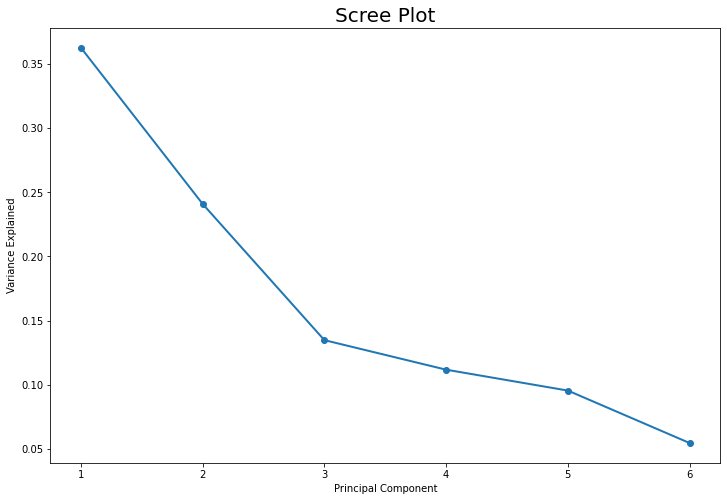

In [20]:
# 評估模型解釋力

print('pca explained variance: \n', pca.explained_variance_)
print('pca explained variance ratio: \n', pca.explained_variance_ratio_)

PC_values = np.arange(pca.n_components_) + 1
plt.subplots(figsize = (12, 8))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2)
plt.title('Scree Plot', fontsize=20)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

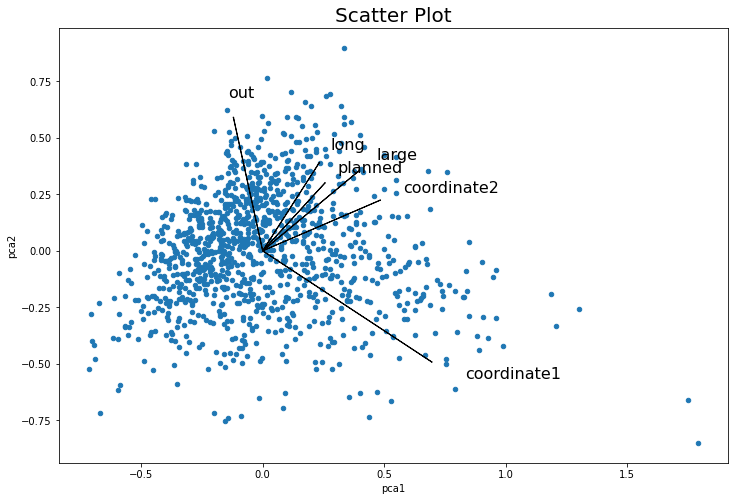

In [21]:
# 對 PCA 結果繪製散佈圖

fig, ax = plt.subplots(figsize = (12, 8))
ceo_type.plot.scatter(x='pca1', y='pca2', ax=ax)

x0 = np.mean(ceo_type['pca1'])
y0 = np.mean(ceo_type['pca2'])

for i in range(6):
  var_name = agg_data_share.columns[i]
  x = eig_vecs[0][i]
  y = eig_vecs[1][i]
  ax.arrow(x0, y0, x, y)
  ax.text(x*1.2+x0, y*1.15+y0, var_name, color = 'k', fontsize=16)

plt.title('Scatter Plot', fontsize=20)
plt.show()

## K_MEANS

In [22]:
k = 2  # k = 群數

x = k_means(agg_data_share.values, k)
print('k-means centroids = \n', x[0])

k-means centroids = 
 [[0.6226148  0.72961737 0.5882037  0.39172078 0.0830315  0.31851491]
 [0.70308735 0.829688   0.72139773 0.26540742 0.58336592 0.52863229]]


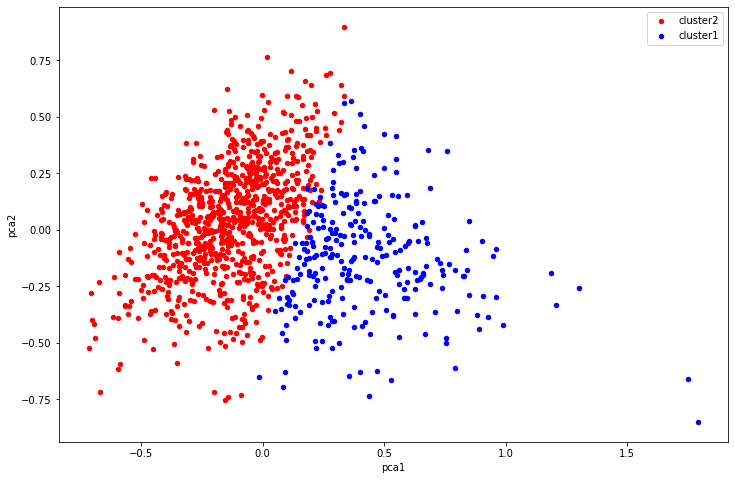

In [23]:
# 對各資料點附加 k-means 分群後的結果
ceo_type['k_means'] = x[1]
agg_data['k_means'] = x[1]

# 分離 cluster0 和 cluster1
ceo_type2 = ceo_type[ceo_type['k_means'] == 0]
agg_data2 = agg_data[agg_data['k_means'] == 0]
ceo_type1 = ceo_type[ceo_type['k_means'] == 1]
agg_data1 = agg_data[agg_data['k_means'] == 1]

# 對 cluster0 和 cluster1 繪製散佈圖
fig, ax = plt.subplots(figsize = (12, 8))
ceo_type2.plot.scatter(x='pca1', y='pca2', color='red', label='cluster2', ax = ax)
ceo_type1.plot.scatter(x='pca1', y='pca2', color='blue', label='cluster1', ax = ax)

## Descriptive statistics of clusters

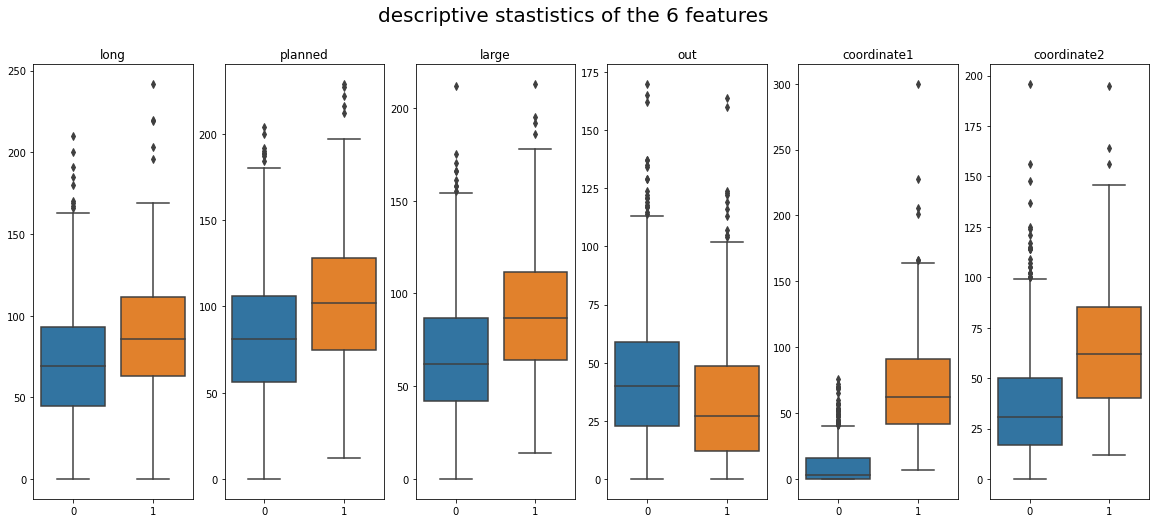

In [24]:
variables = agg_data.columns[:-1]
fig = plt.figure(figsize=(20, 8))
fig.suptitle('descriptive stastistics of the 6 features', fontsize=20)

for i, variable in enumerate(variables, 1):
  plt.subplot(1, 6, i) 
  ax = sns.boxplot(x='k_means', y=variable, data=agg_data)
  ax.set(xlabel=None, ylabel=None, title=variable)

plt.show()

## Output result to file

In [25]:
# 匯出為 csv 檔

ceo_type.to_csv('clusters.csv')
ceo_type.head()

,pca1,pca2,k_means
id,,,
1,0.028047,0.006838,0
2,-0.260733,-0.076089,0
3,-0.058756,0.096061,0
4,0.658277,-0.198954,1
5,0.254779,0.452612,0


# 2. K-means Clustering and Principal Components Analysis with 24 Features

## Read file

In [26]:
ceo_data = pd.read_csv('/content/survey_response_data.csv', low_memory=False)
ceo_data.set_index(['id'], inplace=True)
ceo_data = ceo_data[(ceo_data.level1 == 'interacting')]
ceo_data = ceo_data[ceo_data.type != 'personal_family']
ceo_data = ceo_data[ceo_data.index != 1115]

ceo_data.head()

,finance,mkting,production,strategy,hr,bunits,other,admin,board,chairman,...,pemployee,ins,out,n_functions,type,level1,F_duration,F_planned,F_participants,all_combined
id,,,,,,,,,,,,,,,,,,,,,
607,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,2,meeting,interacting,1hr,planned,two_plus_ppl,interacting__meeting__1hr__planned__two_plus_p...
607,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,2,meeting,interacting,1hr,planned,two_plus_ppl,interacting__meeting__1hr__planned__two_plus_p...
607,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,2,meeting,interacting,1hr,planned,two_plus_ppl,interacting__meeting__1hr__planned__two_plus_p...
607,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,2,meeting,interacting,1hr,planned,two_plus_ppl,interacting__meeting__1hr__planned__two_plus_p...
607,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2,meeting,interacting,1hr,unplanned,two_plus_ppl,interacting__meeting__1hr__unplanned__two_plus...


## Select 24 features

In [27]:
df1 = pd.crosstab(
      ceo_data.index, 
      ceo_data.F_duration
      )
df1.columns = df1.columns.name + '_' + df1.columns
df1

F_duration,F_duration_15m,F_duration_1hr,F_duration_1hrplus,F_duration_30m
row_0,,,,
1,0,16,44,2
2,1,24,106,21
3,3,0,41,10
4,0,0,145,3
5,1,0,129,13
...,...,...,...,...
1110,0,52,70,22
1111,6,36,44,15
1112,1,20,40,8


In [28]:
df2 = pd.crosstab(
      ceo_data[ceo_data.F_planned != 'missing'].index, 
      ceo_data[ceo_data.F_planned != 'missing'].F_planned
      )
df2.columns = df2.columns.name + '_' + df2.columns
df2


F_planned,F_planned_planned,F_planned_unplanned
row_0,,
1,54,8
2,134,18
3,32,22
4,145,3
5,143,0
...,...,...
1110,96,48
1111,54,47
1112,68,1


In [29]:
df3 = pd.crosstab(
      ceo_data[ceo_data.F_participants != 'missing'].index,
      ceo_data[ceo_data.F_participants != 'missing'].F_participants
      )
df3.columns = df3.columns.name + '_' + df3.columns
df3

F_participants,F_participants_one_ppl,F_participants_two_plus_ppl
row_0,,
1,4,58
2,109,43
3,14,40
4,22,126
5,23,120
...,...,...
1110,36,108
1111,82,19
1112,37,32


In [30]:
df5a = pd.crosstab(
      ceo_data.index, 
      ceo_data.out
      )
df5a.rename(columns = {1: df5a.columns.name}, inplace = True)
df5a


out,0.0,out
row_0,,
1,60,2
2,106,46
3,40,14
4,127,21
5,88,55
...,...,...
1110,86,58
1111,71,30
1112,33,36


In [31]:
df_production = pd.crosstab(ceo_data.index, ceo_data.production)
df_production.rename(columns = {1: df_production.columns.name}, inplace = True)

df_groupcom = pd.crosstab(ceo_data.index, ceo_data.groupcom)
df_groupcom.rename(columns = {1: df_groupcom.columns.name}, inplace = True)

df_bunits = pd.crosstab(ceo_data.index, ceo_data.bunits)
df_bunits.rename(columns = {1: df_bunits.columns.name}, inplace = True)

df_coo = pd.crosstab(ceo_data.index, ceo_data.coo)
df_coo.rename(columns = {1: df_coo.columns.name}, inplace = True)

df_cao = pd.crosstab(ceo_data.index, ceo_data.cao)
df_cao.rename(columns = {1: df_cao.columns.name}, inplace = True)


In [32]:
ceo_data['coordinate'] = 0
ceo_data.loc[ceo_data.n_functions > 1, 'coordinate'] = 1
ceo_data['activity_dummy'] = 1
df6 = pd.crosstab(ceo_data.index, ceo_data.coordinate)
df6.rename(columns = {1: df6.columns.name}, inplace = True)

df6

coordinate,0,coordinate
row_0,,
1,50,12
2,126,26
3,30,24
4,110,38
5,34,109
...,...,...
1110,98,46
1111,90,11
1112,55,14


In [33]:
df7 = pd.crosstab(
      ceo_data.index, 
      ceo_data.type
      )

df7.columns = df7.columns.name + '_' + df7.columns

In [34]:
agg_data = pd.DataFrame()
agg_data = pd.concat([agg_data, df1, df2, df3, df5a['out'], df6['coordinate'], df7, df_production['production'], df_groupcom['groupcom'], df_bunits['bunits'], df_coo['coo'], df_cao['cao']], axis=1)
agg_data

,F_duration_15m,F_duration_1hr,F_duration_1hrplus,F_duration_30m,F_planned_planned,F_planned_unplanned,F_participants_one_ppl,F_participants_two_plus_ppl,out,coordinate,...,type_phone_call,type_public_event,type_site_visit,type_video_conference,type_workrelated_leisure,production,groupcom,bunits,coo,cao
1,0,16,44,2,54,8,4,58,2,12,...,0,0,0,0,0,16,4,0,0,0
2,1,24,106,21,134,18,109,43,46,26,...,2,0,0,0,0,38,0,12,0,0
3,3,0,41,10,32,22,14,40,14,24,...,0,0,0,0,0,32,0,0,0,0
4,0,0,145,3,145,3,22,126,21,38,...,0,18,0,0,0,0,108,20,0,0
5,1,0,129,13,143,0,23,120,55,109,...,0,12,0,0,0,47,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,0,52,70,22,96,48,36,108,58,46,...,46,0,0,0,0,30,0,0,0,0
1111,6,36,44,15,54,47,82,19,30,11,...,7,0,0,0,0,2,0,27,0,0
1112,1,20,40,8,68,1,37,32,36,14,...,0,0,0,0,0,6,2,0,6,0
1113,0,8,78,3,89,0,7,82,0,26,...,0,0,0,0,0,0,30,0,0,0


## Descriptive statistics of the dataset

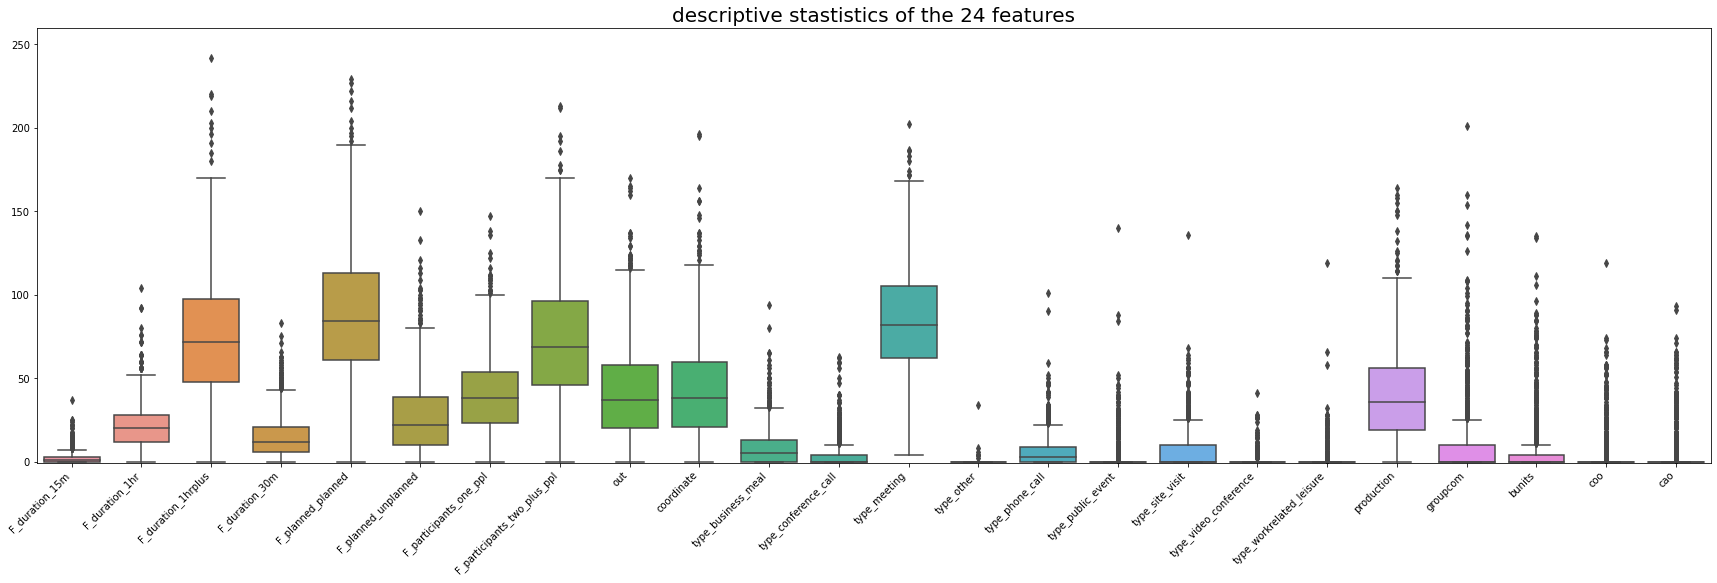

,F_duration_15m,F_duration_1hr,F_duration_1hrplus,F_duration_30m,F_planned_planned,F_planned_unplanned,F_participants_one_ppl,F_participants_two_plus_ppl,out,coordinate,...,type_phone_call,type_public_event,type_site_visit,type_video_conference,type_workrelated_leisure,production,groupcom,bunits,coo,cao
count,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,...,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000
mean,2.280969,21.766607,75.631957,14.860862,87.826750,26.446140,40.166068,72.467684,41.495512,43.301616,...,6.350987,2.614901,6.802513,0.627469,1.396768,40.307899,10.201975,6.877020,3.425494,4.144524
std,3.695880,14.463863,36.760915,12.487817,38.234459,21.534971,23.224601,35.058074,28.544923,30.232294,...,9.202512,9.074108,11.734199,3.094556,6.109559,28.024142,22.105878,17.100048,11.018824,11.815584
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,12.000000,48.000000,6.000000,61.000000,10.000000,23.000000,46.000000,20.000000,21.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,20.000000,72.000000,12.000000,84.000000,22.000000,38.000000,69.000000,37.000000,38.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,36.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,28.000000,97.750000,21.000000,113.000000,38.750000,54.000000,96.000000,58.000000,60.000000,...,9.000000,0.000000,10.000000,0.000000,0.000000,56.000000,10.000000,4.000000,0.000000,0.000000
max,37.000000,104.000000,242.000000,83.000000,229.000000,150.000000,147.000000,213.000000,170.000000,196.000000,...,101.000000,140.000000,136.000000,41.000000,119.000000,164.000000,201.000000,135.000000,119.000000,93.000000


In [35]:
fig = plt.figure(figsize = (30, 8))
sns.boxplot(data = agg_data)
plt.title('descriptive stastistics of the 24 features', fontsize=20)
plt.xticks(rotation=45, ha='right')
plt.ylim(-0.5, 260)
plt.show()

agg_data.describe()

## PRINCIPAL COMPONENTS DECOMPOSITION

In [36]:
# 將各feature以佔每日時間的比例為表示方式

activities = ceo_data['activity_dummy'].groupby(ceo_data.index).agg(np.sum)
agg_data_share = agg_data.div(activities, axis=0)

agg_data_share

,F_duration_15m,F_duration_1hr,F_duration_1hrplus,F_duration_30m,F_planned_planned,F_planned_unplanned,F_participants_one_ppl,F_participants_two_plus_ppl,out,coordinate,...,type_phone_call,type_public_event,type_site_visit,type_video_conference,type_workrelated_leisure,production,groupcom,bunits,coo,cao
1,0.000000,0.258065,0.709677,0.032258,0.870968,0.129032,0.064516,0.935484,0.032258,0.193548,...,0.000000,0.000000,0.0,0.0,0.0,0.258065,0.064516,0.000000,0.000000,0.0
2,0.006579,0.157895,0.697368,0.138158,0.881579,0.118421,0.717105,0.282895,0.302632,0.171053,...,0.013158,0.000000,0.0,0.0,0.0,0.250000,0.000000,0.078947,0.000000,0.0
3,0.055556,0.000000,0.759259,0.185185,0.592593,0.407407,0.259259,0.740741,0.259259,0.444444,...,0.000000,0.000000,0.0,0.0,0.0,0.592593,0.000000,0.000000,0.000000,0.0
4,0.000000,0.000000,0.979730,0.020270,0.979730,0.020270,0.148649,0.851351,0.141892,0.256757,...,0.000000,0.121622,0.0,0.0,0.0,0.000000,0.729730,0.135135,0.000000,0.0
5,0.006993,0.000000,0.902098,0.090909,1.000000,0.000000,0.160839,0.839161,0.384615,0.762238,...,0.000000,0.083916,0.0,0.0,0.0,0.328671,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,0.000000,0.361111,0.486111,0.152778,0.666667,0.333333,0.250000,0.750000,0.402778,0.319444,...,0.319444,0.000000,0.0,0.0,0.0,0.208333,0.000000,0.000000,0.000000,0.0
1111,0.059406,0.356436,0.435644,0.148515,0.534653,0.465347,0.811881,0.188119,0.297030,0.108911,...,0.069307,0.000000,0.0,0.0,0.0,0.019802,0.000000,0.267327,0.000000,0.0
1112,0.014493,0.289855,0.579710,0.115942,0.985507,0.014493,0.536232,0.463768,0.521739,0.202899,...,0.000000,0.000000,0.0,0.0,0.0,0.086957,0.028986,0.000000,0.086957,0.0
1113,0.000000,0.089888,0.876404,0.033708,1.000000,0.000000,0.078652,0.921348,0.000000,0.292135,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.337079,0.000000,0.000000,0.0


In [37]:
pca = PCA(n_components=20)
pca.fit(agg_data_share)
agg_data_share_pca = pca.transform(agg_data_share)
agg_data_share_pca

array([[-2.98441001e-01,  7.92874208e-02, -1.43008060e-01, ...,
         6.94151301e-03, -1.50663426e-02, -4.20392685e-04],
       [ 2.95136709e-01, -3.40029547e-01, -2.94077120e-01, ...,
        -9.78577361e-03, -1.45185531e-03, -2.10881945e-03],
       [-9.69658078e-02,  2.94747673e-01,  1.67930517e-01, ...,
         2.80407377e-02,  7.79344504e-03,  1.93641913e-03],
       ...,
       [ 1.03246835e-01, -4.71100590e-01, -1.99757840e-01, ...,
         1.05154532e-02, -1.84432637e-03, -2.46047156e-03],
       [-4.80235274e-01, -1.63437912e-01, -1.81042477e-01, ...,
         6.66135699e-03, -1.57259696e-02, -4.22648525e-03],
       [ 3.32573010e-01, -2.72936952e-01, -3.54736620e-01, ...,
        -4.08258477e-02, -8.29206468e-03,  3.52299147e-05]])

In [38]:
# # 以 dataframe 格式儲存 pca 結果

ceo_type = pd.DataFrame(index=agg_data_share.index)
ceo_type.index.name = 'id'

ceo_type['pca1'] = agg_data_share_pca[:, 0]
ceo_type['pca2'] = agg_data_share_pca[:, 1]

ceo_type.head()

,pca1,pca2
id,,
1,-0.298441,0.079287
2,0.295137,-0.340030
3,-0.096966,0.294748
4,-0.484618,-0.282347
5,-0.633580,-0.100751


In [39]:
# 特徵向量

eig_vecs = pca.components_
print('pca eigenvectors: \n', eig_vecs[:5])

# 每行為一個特徵向量（只輸出前5個），每個特徵向量有24個維度

pca eigenvectors: 
 [[ 3.73235296e-02  1.10757275e-01 -3.03505255e-01  1.55424450e-01
  -3.49793109e-01  3.48806192e-01  4.49968409e-01 -4.62141546e-01
  -6.25116260e-02 -4.00485223e-01 -2.05332894e-02 -5.92824742e-03
  -6.03368878e-02 -7.16045373e-05  1.04423933e-01 -3.26006806e-02
   2.54180942e-02 -1.13234011e-03 -9.23897721e-03 -1.15066719e-01
  -1.04585482e-01 -5.55237800e-02 -2.58257910e-02 -3.12823261e-02]
 [ 1.76670780e-02  1.16842654e-01 -2.56991703e-01  1.22481970e-01
  -3.21251380e-01  3.16149070e-01 -2.22204635e-01  2.07684076e-01
  -4.72032576e-01  2.50482220e-01 -4.88473970e-02  3.55707376e-02
  -7.78219653e-03  3.51885620e-04 -8.65833149e-03 -4.56584640e-02
   8.30935717e-02  2.28425046e-03 -1.03540564e-02  5.54198075e-01
   4.31962296e-02  1.02886277e-02  2.96667318e-02  2.99448507e-02]
 [ 8.73818475e-03 -1.81097655e-01  2.17129977e-01 -4.47705072e-02
  -4.92003422e-01  4.88229807e-01 -2.13274690e-01  2.18582210e-01
   4.94129081e-01  1.66545984e-01  4.09166205e-02 -3.0

pca explained variance: 
 [0.13114695 0.07590456 0.05371512 0.04296088 0.03742167 0.03218849
 0.02444655 0.01709077 0.0129102  0.01197879 0.00967676 0.0083504
 0.00731257 0.006339   0.00419912 0.00372193 0.00206911 0.00130535
 0.00105771 0.00064429]
pca explained variance ratio: 
 [0.27048065 0.1565474  0.11078336 0.08860355 0.07717936 0.06638633
 0.05041916 0.03524841 0.02662631 0.02470535 0.01995759 0.01722207
 0.01508163 0.0130737  0.00866036 0.00767619 0.00426737 0.00269218
 0.00218145 0.00132881]


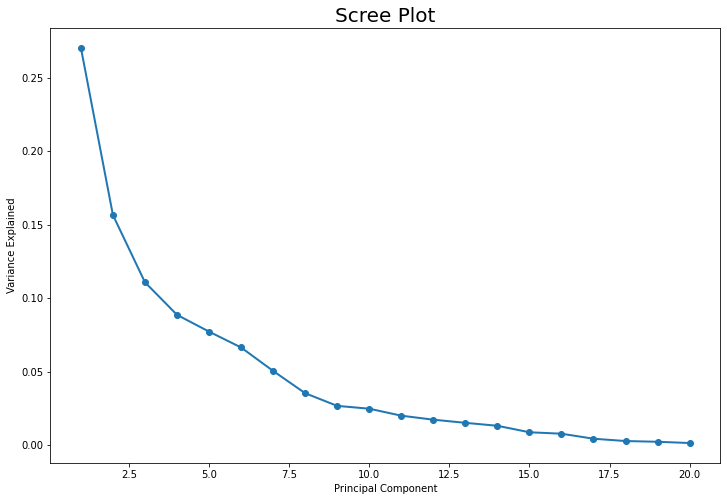

In [40]:
# 評估模型解釋力

print('pca explained variance: \n', pca.explained_variance_)
print('pca explained variance ratio: \n', pca.explained_variance_ratio_)

PC_values = np.arange(pca.n_components_) + 1
plt.subplots(figsize = (12, 8))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2)
plt.title('Scree Plot', fontsize=20)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

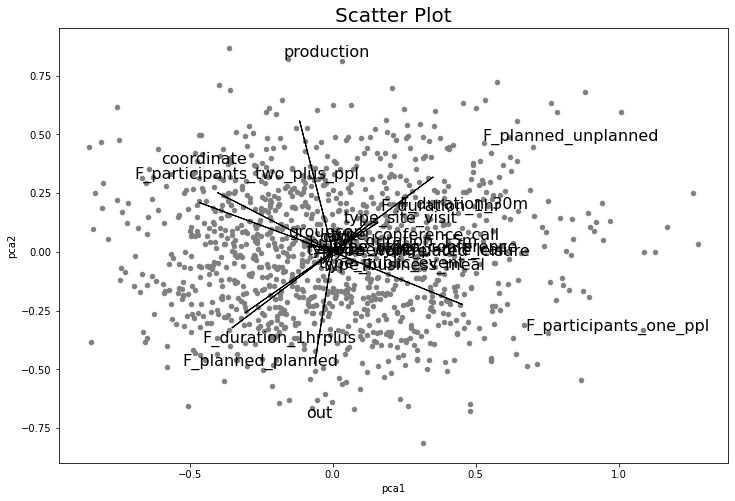

In [41]:
# 對 PCA 結果繪製散佈圖

fig, ax = plt.subplots(figsize = (12, 8))
ceo_type.plot.scatter(x='pca1', y='pca2', ax=ax, color='gray')

x0 = np.mean(ceo_type['pca1'])
y0 = np.mean(ceo_type['pca2'])

for i in range(len(agg_data_share.columns)):
  var_name = agg_data_share.columns[i]
  x = eig_vecs[0][i]
  y = eig_vecs[1][i]
  ax.arrow(x0, y0, x, y)
  ax.text(x*1.5+x0, y*1.5+y0, var_name, color = 'k', fontsize=16)


plt.title('Scatter Plot', fontsize=20)
plt.show()

## K_MEANS

In [42]:
k = 2  # k = 群數

x = k_means(agg_data_share.values, k)
print('k-means centroids = \n', x[0])

k-means centroids = 
 [[1.33712406e-02 1.71835816e-01 7.13020785e-01 1.01772159e-01
  8.42516525e-01 1.56494952e-01 2.39169886e-01 7.47300776e-01
  3.74779374e-01 4.76339609e-01 7.55479644e-02 3.47657077e-02
  7.55501320e-01 6.59529939e-04 3.43212777e-02 2.82859642e-02
  5.19077875e-02 5.41609036e-03 1.35943586e-02 3.88689111e-01
  1.07879359e-01 6.76678477e-02 3.62363509e-02 4.39016394e-02]
 [3.32490323e-02 2.30851008e-01 5.52968071e-01 1.82931889e-01
  6.42413895e-01 3.54639168e-01 5.16625849e-01 4.61096058e-01
  3.44773433e-01 2.34490362e-01 6.24071711e-02 3.17520579e-02
  7.21922408e-01 9.48419772e-05 9.23794978e-02 1.02466531e-02
  6.80256461e-02 4.70521817e-03 8.46650579e-03 3.09468420e-01
  4.70290020e-02 4.00634369e-02 2.29998197e-02 2.69122684e-02]]


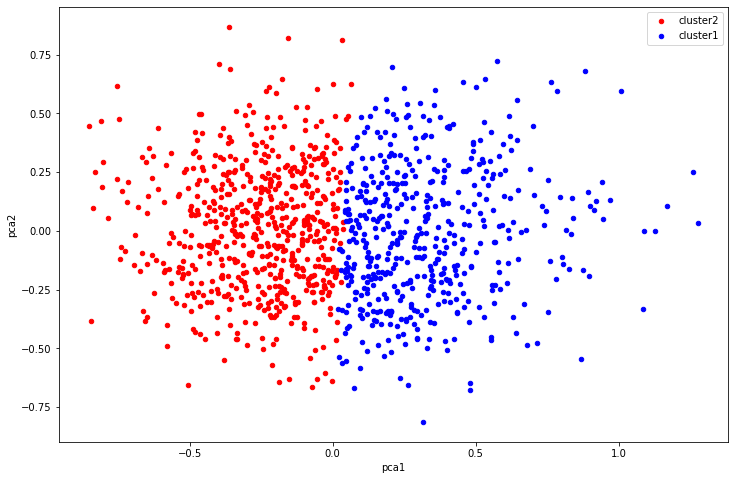

In [43]:
# 對各資料點附加 k-means 分群後的結果
ceo_type['k_means'] = x[1]
agg_data['k_means'] = x[1]

# 分離 cluster0 和 cluster1
ceo_type2 = ceo_type[ceo_type['k_means'] == 0]
agg_data2 = agg_data[agg_data['k_means'] == 0]
ceo_type1 = ceo_type[ceo_type['k_means'] == 1]
agg_data1 = agg_data[agg_data['k_means'] == 1]

# 對 cluster0 和 cluster1 繪製散佈圖
fig, ax = plt.subplots(figsize = (12, 8))
ceo_type2.plot.scatter(x='pca1', y='pca2', color='red', label='cluster2', ax = ax)
ceo_type1.plot.scatter(x='pca1', y='pca2', color='blue', label='cluster1', ax = ax)

In [44]:
agg_data1.describe()

,F_duration_15m,F_duration_1hr,F_duration_1hrplus,F_duration_30m,F_planned_planned,F_planned_unplanned,F_participants_one_ppl,F_participants_two_plus_ppl,out,coordinate,...,type_public_event,type_site_visit,type_video_conference,type_workrelated_leisure,production,groupcom,bunits,coo,cao,k_means
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,...,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.0
mean,3.226263,23.692929,59.701010,18.606061,68.618182,36.143434,53.862626,49.012121,35.816162,24.977778,...,1.280808,7.373737,0.547475,0.985859,32.527273,5.349495,4.662626,2.448485,2.856566,1.0
std,4.572550,14.521889,30.348907,14.393556,31.890210,22.659816,22.697209,23.021286,22.798105,17.318916,...,5.427842,12.763487,2.807103,4.723724,22.154654,13.905737,12.011015,8.791378,8.324251,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,12.000000,38.000000,8.000000,46.000000,20.000000,39.000000,34.000000,17.000000,11.500000,...,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,2.000000,20.000000,57.000000,16.000000,67.000000,34.000000,51.000000,48.000000,32.000000,23.000000,...,0.000000,2.000000,0.000000,0.000000,29.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,5.000000,32.000000,77.000000,26.000000,89.000000,48.000000,67.000000,63.000000,51.500000,37.000000,...,0.000000,10.000000,0.000000,0.000000,44.500000,2.500000,0.000000,0.000000,0.000000,1.0
max,37.000000,92.000000,191.000000,83.000000,192.000000,150.000000,147.000000,145.000000,121.000000,105.000000,...,44.000000,136.000000,27.000000,66.000000,155.000000,126.000000,89.000000,66.000000,59.000000,1.0


In [45]:
variables = abs(agg_data2.mean()[:-1] - agg_data1.mean()[:-1]).sort_values().keys()
variables1 = variables[:12]
variables2 = variables[12:]

## Descriptive statistics of clusters

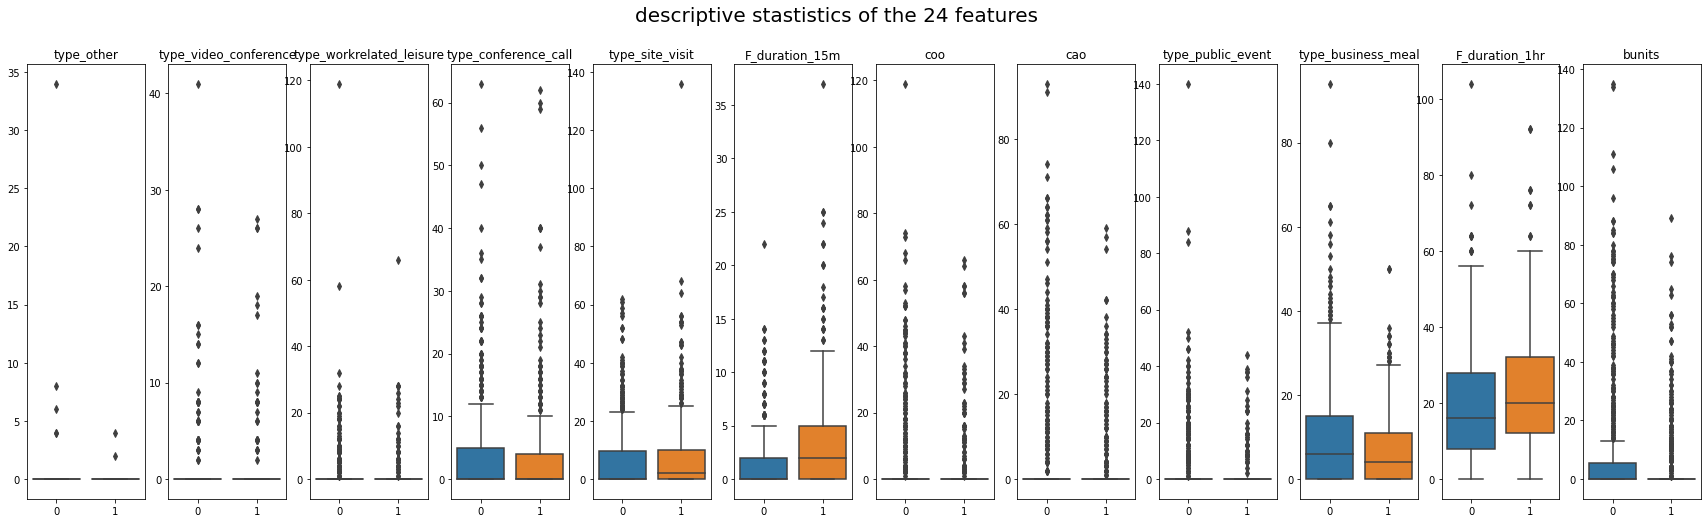

In [46]:
fig = plt.figure(figsize=(30, 8))
fig.suptitle('descriptive stastistics of the 24 features', fontsize=20)

for i, variable in enumerate(variables1, 1):
  plt.subplot(1, 12, i) 
  ax = sns.boxplot(x='k_means', y=variable, data=agg_data)
  ax.set(xlabel=None, ylabel=None, title=variable)

plt.show()

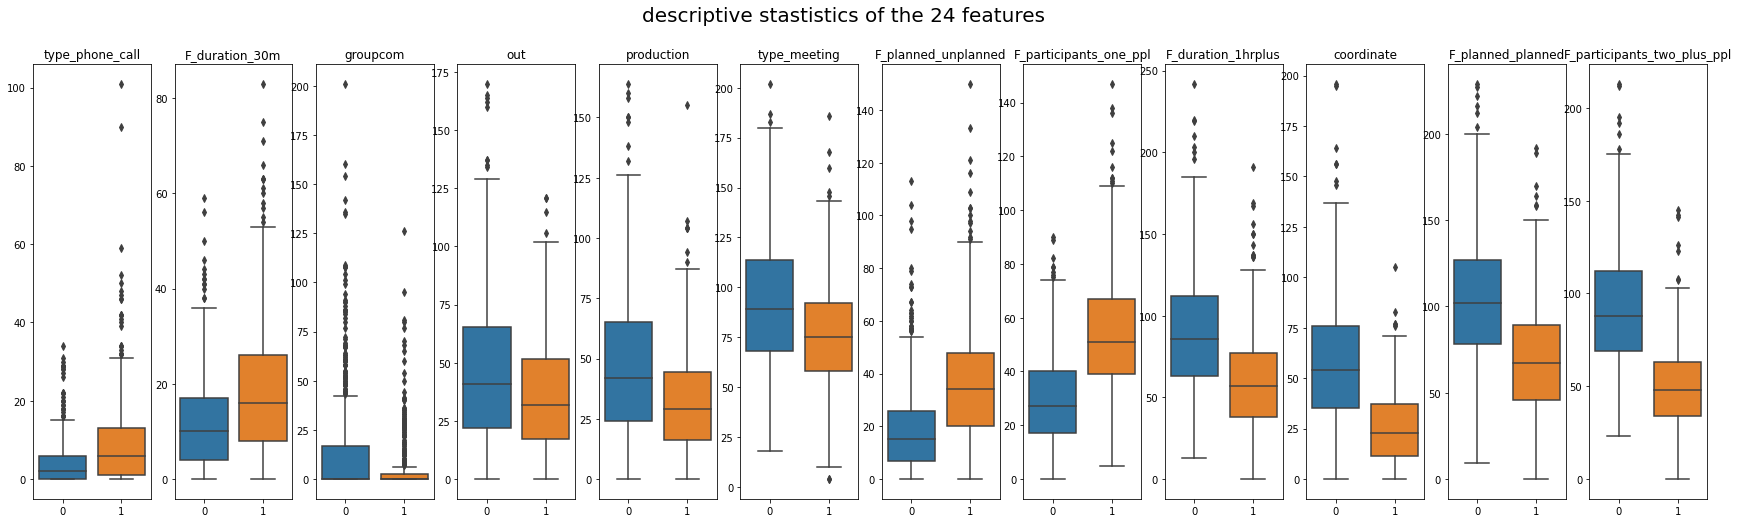

In [47]:
fig = plt.figure(figsize=(30, 8))
fig.suptitle('descriptive stastistics of the 24 features', fontsize=20)

for i, variable in enumerate(variables2, 1):
  plt.subplot(1, 12, i) 
  ax = sns.boxplot(x='k_means', y=variable, data=agg_data)
  ax.set(xlabel=None, ylabel=None, title=variable)

plt.show()

## Output result to file

In [48]:
# 匯出為 csv 檔

ceo_type.to_csv('clusters.csv')
ceo_type.head()

,pca1,pca2,k_means
id,,,
1,-0.298441,0.079287,0
2,0.295137,-0.340030,1
3,-0.096966,0.294748,0
4,-0.484618,-0.282347,0
5,-0.633580,-0.100751,0
